In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts
import dadrah.kfold_pipeline.kfold_string_constants as kstco
import dadrah.kfold_pipeline.kfold_util as kutil

import pathlib
import argparse
import scipy
from scipy.stats import kstwo
from scipy.stats import chi2

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
from recordtype import recordtype
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
import cmsstyle #mplhep for Python2 cheatsheet

Welcome to JupyROOT 6.22/00


In [2]:
scipy.__version__

'1.5.1'

## runtime params

### change:

In [201]:
Parameters = recordtype('Parameters','qr_run_n, quantiles, qcd_sample_id, sig_sample_id, sig_xsec, score_strategy_id, read_n, env_run_n, poly_run_n')
params = Parameters(qr_run_n=412,
                    quantiles=[0.3, 0.5, 0.7, 0.9],
                    qcd_sample_id='qcdSigAll', 
                    sig_sample_id='GtoWW35naReco',
                    sig_xsec=0,
                    score_strategy_id='rk5_05',
                    read_n=None,
                    env_run_n=4,
                    poly_run_n=0,
                    )

qr_model_str = '_'.join(['kfold',str(params.qr_run_n),str(params.env_run_n),str(params.poly_run_n)])
train_share = 0

xsec = 0
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
#quantiles = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
#quantiles = [0.3, 0.5, 0.7, 0.9]
#quantiles = [0.5, 0.9]
#quantiles = [0.1, 0.5, 0.99]

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0

# paths
input_path = kstco.get_polynomials_out_data_dir(params)
fig_dir = 'fig/qr_run_'+str(int(params.qr_run_n))+'/env_run_'+str(int(params.env_run_n))+'/poly_run_'+str(int(params.poly_run_n))
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

xsecs_sig   = [0,20,40,60,80,100] # signal cross sections

file_name_root_hist = 'histograms_injSig_PDinj_NA3p5_r'+str(params.qr_run_n)+'.root'
#quants = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quants = [0.0, 0.3, 0.5, 0.7, 0.9]
#quants = [0.0, 0.7]

In [202]:
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
template_q_idx = 0
quant_tmplt = quants[template_q_idx]

In [203]:
# if poly_cut:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig[:-4], 'xsec': str(int(xsec_train)), 'loss': 'rk5_05', 'order':'5'}
# else:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
# paths.extend_in_path_data(path_ext_dict)
# paths.extend_out_path_data({**path_ext_dict, 'hypothesis_testing': None})

### fixed

In [204]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = (1-train_share)*sig_xsec_default*lumi/sig_gen_events #X% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0006582093252100682


In [205]:
# efficiencies
quants_tmp = np.asarray(quants+[1.])
effs = (quants_tmp)[template_q_idx+1:] - (quants_tmp)[template_q_idx:-1]
effs = effs[1:]/effs[0] # scale down instead of up (apply to template quantile)

In [206]:
effs

array([0.6667, 0.6667, 0.6667, 0.3333])

In [207]:
min_mjj = 1200.
max_mjj = 5400.

bin_edges = kutil.get_bins_from_envelope(params)
bin_edges = bin_edges[(bin_edges>=min_mjj) & (bin_edges<=max_mjj)]
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [208]:
bin_edges

array([1231.5133, 1296.7513, 1366.528 , 1441.0818, 1520.662 , 1605.5294,
       1695.9571, 1792.2308, 1894.6494, 2003.5255, 2119.1863, 2241.9737,
       2372.2456, 2510.3758, 2656.7554, 2811.7934, 2975.917 , 3149.5729,
       3333.228 , 3527.3701, 3732.5091, 3949.1776, 4177.9321, 4419.3539,
       4674.0504, 4942.6559, 5225.8327])

In [209]:
min_mjj = bin_edges[0]

## read histogram data

In [210]:
def read_root_hist_data(file_name):
    
    hist_data = {}
    ff = rt.TFile.Open(file_name,'r')

    # read bins from template quantile
    dat = ff.Get('data_acc_{}fb_q{}p'.format(0,int(100))); dat.SetDirectory(0);
    bin_centers = np.asarray([dat.GetXaxis().GetBinCenter(j) for j in range(1,dat.GetNbinsX()+1)])

    # for each quantile
    for i, quant in enumerate(quants):

        hist_data_quant = {}
        q_key = quants[i]*100

        # for each signal injection
        for xsec in xsecs_sig:

            dat = ff.Get('data_acc_{}fb_q{}p'.format(xsec,int(q_key))); dat.SetDirectory(0);
            yy = np.asarray([dat.GetBinContent(j) for j in range(1,dat.GetNbinsX()+1)])

            hist_data_quant[xsec] = yy

        hist_data[quant] = hist_data_quant
        
    return bin_centers, hist_data

In [211]:
def read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths):
    samples = {}

#     for sample_id in sample_ids:
#         samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    for sample_id in sample_ids:
        in_path = os.path.join(paths,sample_id+'.h5') #paths.in_file_path(sample_id)
        samples[sample_id] = js.JetSample.from_input_file(sample_id, in_path)
        print('read ' + str(len(samples[sample_id])) + ' ' + sample_id + ' samples from ' + in_path)
    
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles[1:])
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles[1:])
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    return mjj_vals_qcd, mjj_vals_sig

In [212]:
def read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths):
    
    mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quantiles[template_q_idx:]:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            scale_xsec_sig = xsec/sig_xsec_default
            sig_inj = datas_sig[quant]*scale_sig*scale_xsec_sig
            # TODO: sample sig bin height from poisson?
            
            histos_data_inj_quant[xsec] = dat + sig_inj
            
        histos_data_inj[quant] = histos_data_inj_quant
            
    return bin_edges[:-1], histos_data_inj     
    

read 11985958 qcdSigAll samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_412/env_run_4/poly_run_0/qcdSigAll.h5
read 531825 GtoWW35naReco samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_412/env_run_4/poly_run_0/GtoWW35naReco.h5


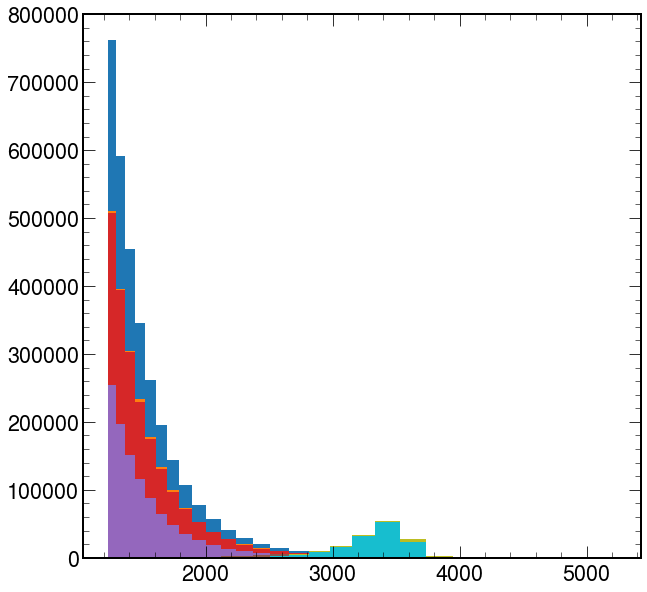

In [213]:
#bin_centers, hist_data = read_root_hist_data(file_name_root_hist)
bin_centers, hist_data = read_raw_selection_data_to_numpy_hist(quants, 113, params.qr_run_n, sample_id_sig, xsec_train, bin_edges, input_path)

In [214]:
quants

[0.0, 0.3, 0.5, 0.7, 0.9]

## plot histograms

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


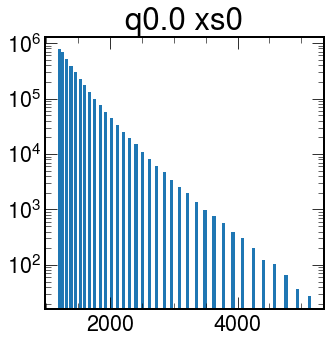

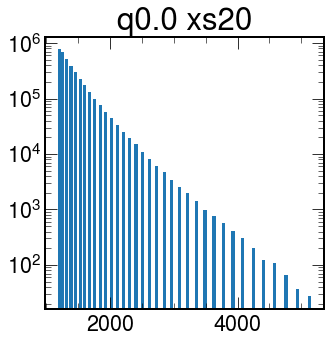

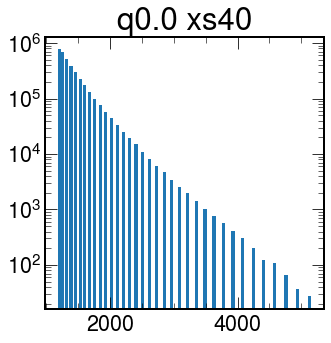

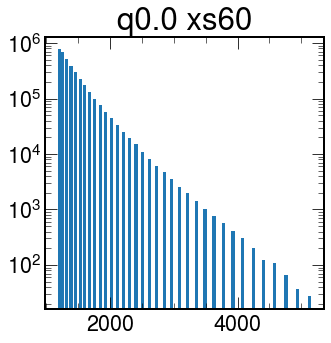

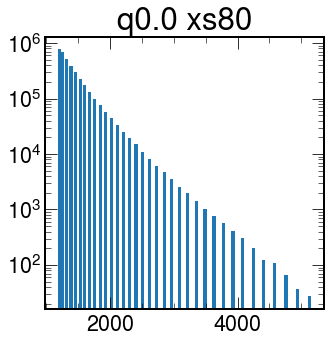

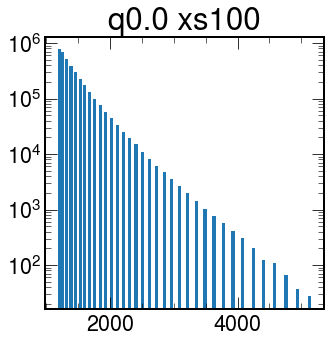

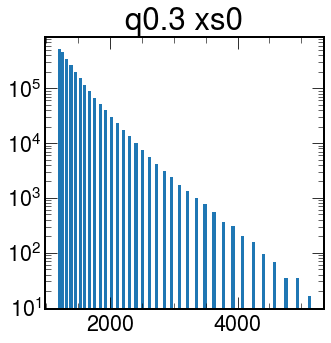

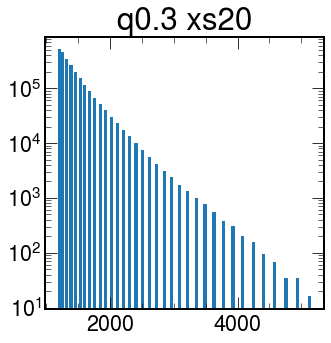

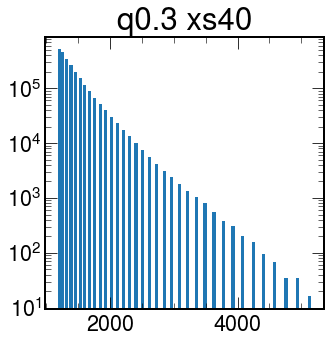

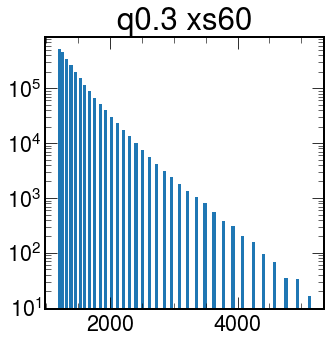

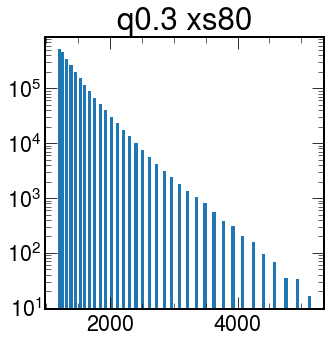

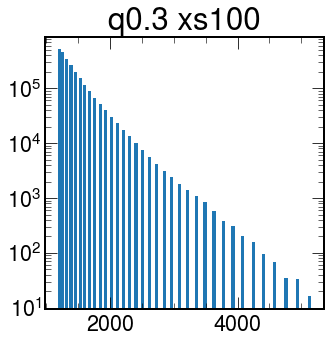

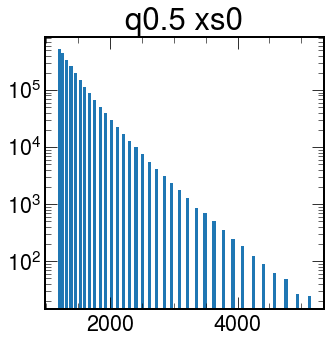

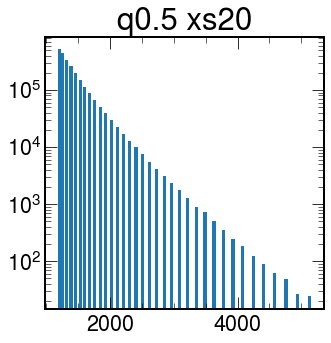

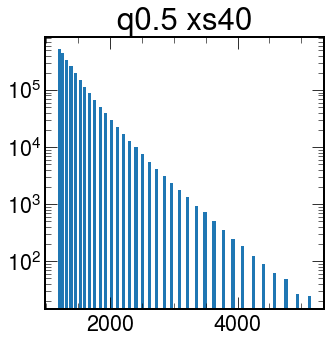

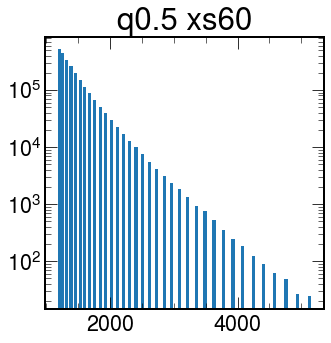

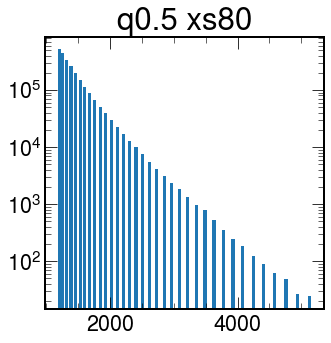

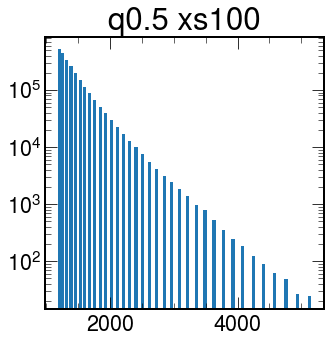

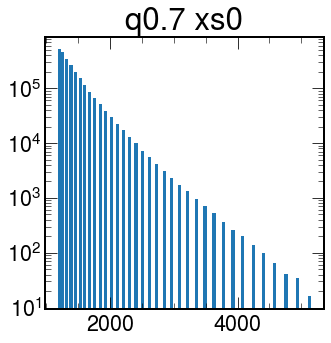

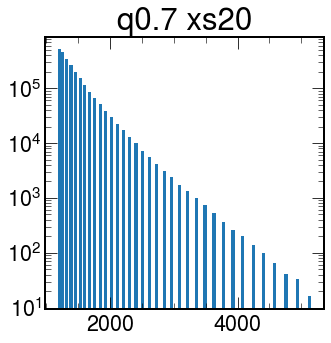

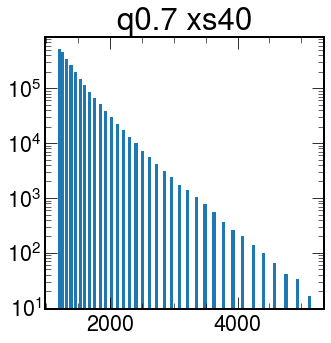

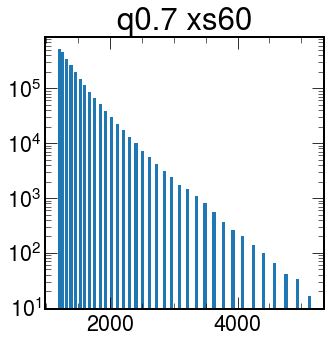

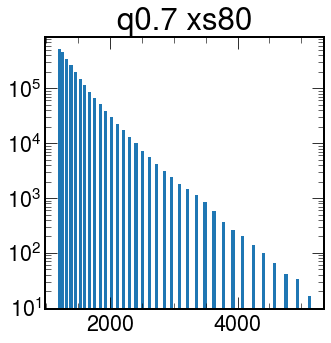

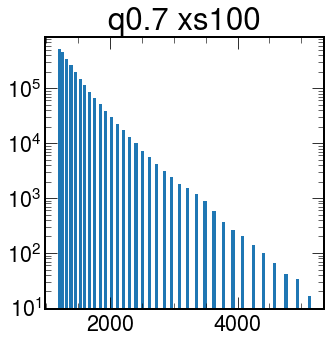

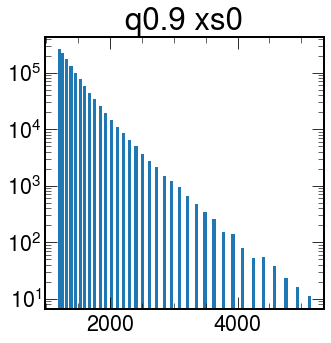

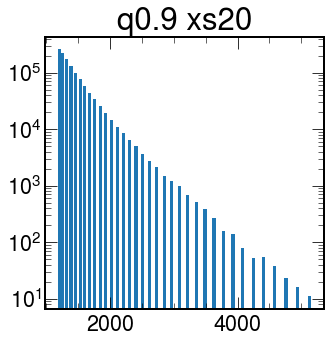

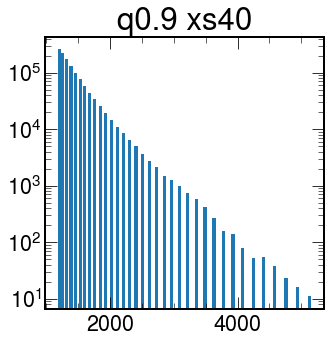

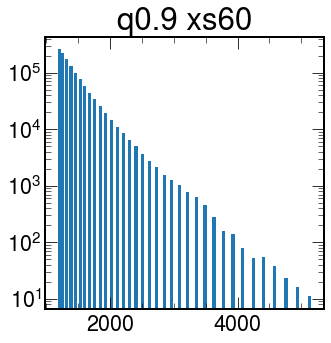

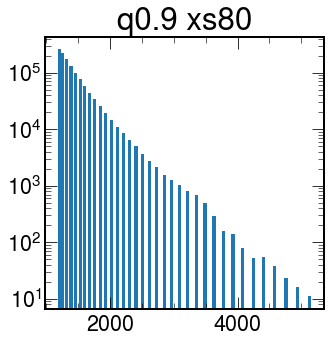

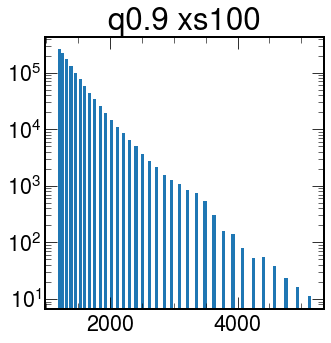

In [66]:
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        plt.figure(figsize=(5, 5))
        plt.bar(bin_centers, yy, width=50, log=True)
        plt.title('q{} xs{}'.format(quant, xsec))

In [215]:
# print N samples
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        print('quant {:>4}, xsec {:>3}: {:>8} events'.format(quant, xsec, int(sum(yy))))

quant  0.0, xsec   0:  3131636 events
quant  0.0, xsec  20:  3131726 events
quant  0.0, xsec  40:  3131817 events
quant  0.0, xsec  60:  3131908 events
quant  0.0, xsec  80:  3131999 events
quant  0.0, xsec 100:  3132089 events
quant  0.3, xsec   0:  2110913 events
quant  0.3, xsec  20:  2110999 events
quant  0.3, xsec  40:  2111086 events
quant  0.3, xsec  60:  2111173 events
quant  0.3, xsec  80:  2111259 events
quant  0.3, xsec 100:  2111346 events
quant  0.5, xsec   0:  2057851 events
quant  0.5, xsec  20:  2057968 events
quant  0.5, xsec  40:  2058085 events
quant  0.5, xsec  60:  2058203 events
quant  0.5, xsec  80:  2058320 events
quant  0.5, xsec 100:  2058437 events
quant  0.7, xsec   0:  2085160 events
quant  0.7, xsec  20:  2085371 events
quant  0.7, xsec  40:  2085583 events
quant  0.7, xsec  60:  2085795 events
quant  0.7, xsec  80:  2086007 events
quant  0.7, xsec 100:  2086219 events
quant  0.9, xsec   0:  1044548 events
quant  0.9, xsec  20:  1044740 events
quant  0.9, 

# Chi Square tests

In [216]:
def chi_square_pearson(observed, expected):
    statistics_per_bin = [(o-e)**2/e for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [217]:
def chi_square_neyman(observed, expected):
    statistics_per_bin = [(o-e)**2/max(o,1) for o, e in zip(observed, expected)] # adapted to zero bin counts
    return sum(statistics_per_bin), statistics_per_bin

In [218]:
def chi_square_poisson_likeli(observed, expected):
    statistics_per_bin = [2*(e - o + (o * np.log(o/e) if o else 0)) for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [219]:
np.set_printoptions(precision=4, suppress=False)

In [220]:
df = n_bins - 1 # degrees of freedom = number of measurements (=bins) - 1

chi_sq_pearson_stats = {}
chi_sq_neyman_stats = {}
chi_sq_poisson_like = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_p = []
    pvals_p = []
    test_stat_xsecs_n = []
    pvals_n = []
    test_stat_xsecs_l = []
    pvals_l = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        t_p, _ = chi_square_pearson(observed, expected)
        pval_p = 1 - chi2.cdf(t_p, df=df)
        t_n, _ = chi_square_neyman(observed, expected)
        pval_n = 1 - chi2.cdf(t_n, df=df)
        t_l, _ = chi_square_poisson_likeli(observed, expected)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        test_stat_xsecs_p.append(t_p)
        test_stat_xsecs_n.append(t_n)
        test_stat_xsecs_l.append(t_l)
        pvals_p.append(pval_p)
        pvals_n.append(pval_n)
        pvals_l.append(pval_l)
    
    print('pearson for quantile', quant_test)
    print('ch2:' , np.array(test_stat_xsecs_p))
    print('p-val: ', np.array(pvals_p))
    print('neyman for quantile', quant_test)
    print(np.array(test_stat_xsecs_n))
    print('p-val: ', np.array(pvals_n))
    print('likelihood for quantile', quant_test)
    print(np.array(test_stat_xsecs_l))
    print('p-val: ', np.array(pvals_l))
    print('\n')
    
    chi_sq_pearson_stats[quant_test] = test_stat_xsecs_p
    chi_sq_neyman_stats[quant_test] = test_stat_xsecs_n
    chi_sq_poisson_like[quant_test] = test_stat_xsecs_l

pearson for quantile 0.3
ch2: [445.6428 448.7431 452.2455 456.1431 460.4292 465.0973]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.3
[434.7583 437.5326 440.6385 444.0637 447.7965 451.8259]
p-val:  [0. 0. 0. 0. 0. 0.]
likelihood for quantile 0.3
[441.9531 444.9394 448.3025 452.0334 456.1234 460.564 ]
p-val:  [0. 0. 0. 0. 0. 0.]


pearson for quantile 0.5
ch2: [644.1128 642.5026 642.542  644.2023 647.4557 652.2749]
p-val:  [0. 0. 0. 0. 0. 0.]
neyman for quantile 0.5
[660.6314 658.8091 658.713  660.2324 663.2665 667.7233]
p-val:  [0. 0. 0. 0. 0. 0.]
likelihood for quantile 0.5
[649.5255 647.8463 647.8403 649.4524 652.6299 657.3231]
p-val:  [0. 0. 0. 0. 0. 0.]


pearson for quantile 0.7
ch2: [ 28.6215  35.5955  52.3536  78.7239 114.5389 159.6347]
p-val:  [2.8005e-01 7.7966e-02 1.0811e-03 1.8059e-07 2.0095e-13 0.0000e+00]
neyman for quantile 0.7
[ 28.3443  34.9987  50.2073  72.9454 102.3566 137.7185]
p-val:  [2.9225e-01 8.8226e-02 2.0092e-03 1.3927e-06 2.5082e-11 0.0000e+00]
likelihood

### draw test statistics on chi-square distribution graph

saving fig to  fig/qr_run_412/env_run_4/poly_run_0/chi_square_Pearson.png
saving fig to  fig/qr_run_412/env_run_4/poly_run_0/chi_square_Neyman.png
saving fig to  fig/qr_run_412/env_run_4/poly_run_0/chi_square_PoissonLike.png


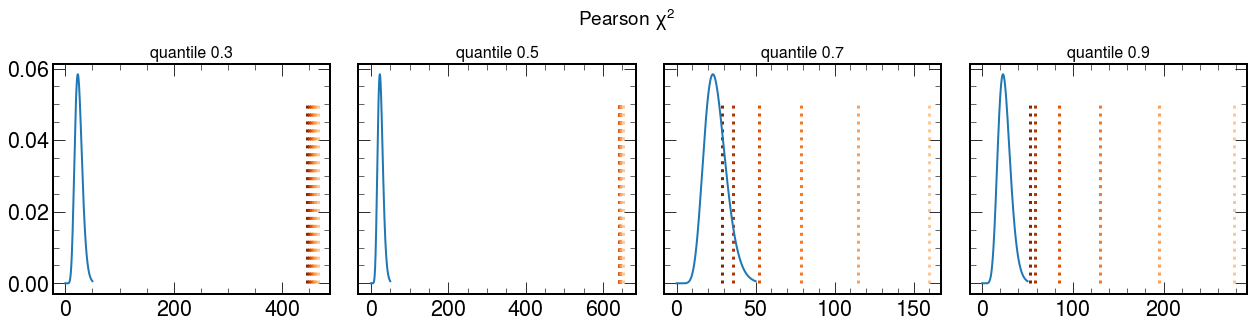

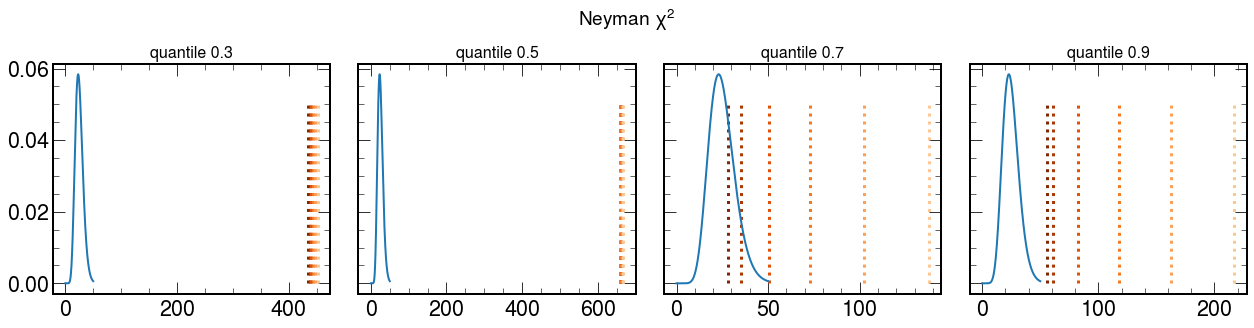

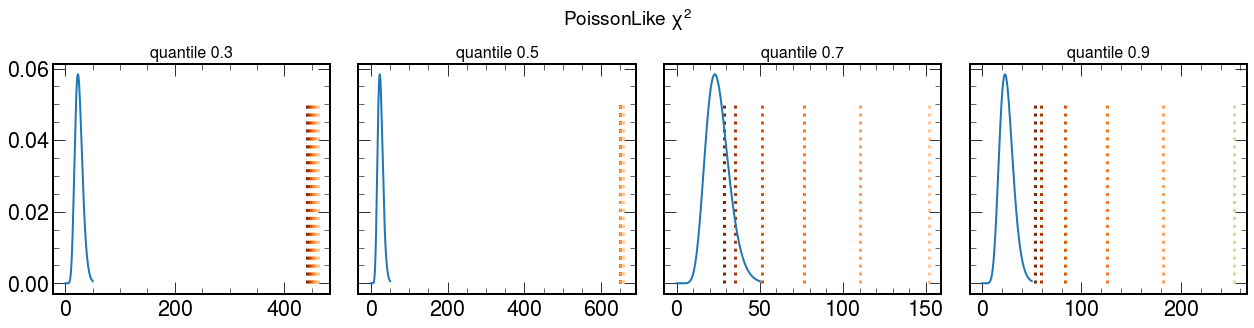

In [221]:
chi_sq_results = {
    'Pearson': chi_sq_pearson_stats,
    'Neyman' : chi_sq_neyman_stats,
    'PoissonLike': chi_sq_poisson_like
}

x = np.arange(0, df*2, 0.001)
cmap = cm.get_cmap('Oranges')
cmap = cmap(np.linspace(0.0, 1.0, len(xsecs_sig)+2))[::-1]

for method, val_dict in chi_sq_results.items():
    fig, axs = plt.subplots(1,len(quants)-1,sharey=True,figsize=(18,5))
    for quant, ax in zip(quants[template_q_idx+1:],axs.flat):
        chi_sq_vals = val_dict[quant]
        ax.plot(x, chi2.pdf(x, df=df), lw=2) # df = num-observed - 1
        ax.vlines(chi_sq_vals,colors=cmap,ymin=0,ymax=0.05, ls=':',lw=3)
        ax.set_title('quantile {}'.format(quant), fontsize=16)
    fig.suptitle(r'{} $\chi^2$'.format(method), fontsize=19)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(fig_dir,'chi_square_{}.png'.format(method))
    print('saving fig to ', fig_path)
    plt.savefig(fig_path)

In [222]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    test_stat_xsecs_p = []
    test_stat_xsecs_n = []
    for xsec in [xsecs_sig[0]]:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        print('\nquant ' +str(quant_test)+', xsec '+ str(xsec))
        print('obs')
        print(np.array(observed))
        print('total events ' + str(sum(observed)))
        print('exp')
        print(np.array(expected))


quant 0.3, xsec 0
obs
[5.1085e+05 3.9576e+05 3.0441e+05 2.3341e+05 1.7804e+05 1.3362e+05
 9.9314e+04 7.2627e+04 5.3166e+04 3.8536e+04 2.7559e+04 1.9808e+04
 1.3969e+04 9.7910e+03 6.6530e+03 4.5220e+03 3.1410e+03 2.0470e+03
 1.3960e+03 9.2400e+02 5.4400e+02 3.6500e+02 2.3100e+02 1.2800e+02
 6.2000e+01 3.8000e+01]
total events 2110913.0
exp
[5.0797e+05 3.9454e+05 3.0333e+05 2.3083e+05 1.7408e+05 1.3077e+05
 9.6376e+04 7.1041e+04 5.2113e+04 3.7643e+04 2.7213e+04 1.9218e+04
 1.3741e+04 9.5173e+03 6.3320e+03 4.5120e+03 2.9867e+03 2.0387e+03
 1.3027e+03 8.6000e+02 5.4400e+02 3.5933e+02 2.1933e+02 1.1667e+02
 7.1333e+01 3.7333e+01]

quant 0.5, xsec 0
obs
[5.0579e+05 3.9248e+05 2.9928e+05 2.2557e+05 1.6979e+05 1.2632e+05
 9.4347e+04 6.9521e+04 5.0578e+04 3.6803e+04 2.6381e+04 1.8878e+04
 1.3416e+04 9.4970e+03 6.3530e+03 4.4040e+03 3.0170e+03 2.0030e+03
 1.2330e+03 8.7800e+02 5.2800e+02 3.2200e+02 2.1200e+02 1.2200e+02
 8.4000e+01 4.0000e+01]
total events 2057851.0
exp
[5.0797e+05 3.9454e+05 3

In [223]:
dat_tmplt = hist_data[quant_tmplt]

In [224]:
for quant, eff in zip(quants[template_q_idx+1:], effs):
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
    print('pvals for quantile {}'.format(quant))
    print(xsecs_sig)
    print(np.asarray(p_vals))

pvals for quantile 0.3
[0, 20, 40, 60, 80, 100]
[1.3124e-78 3.0152e-79 5.7205e-80 8.9896e-81 1.1736e-81 1.2765e-82]
pvals for quantile 0.5
[0, 20, 40, 60, 80, 100]
[7.1352e-120 1.5510e-119 1.5218e-119 6.8339e-120 1.4232e-120 1.3923e-121]
pvals for quantile 0.7
[0, 20, 40, 60, 80, 100]
[2.8005e-01 7.7966e-02 1.0811e-03 1.8059e-07 2.0099e-13 1.3810e-21]
pvals for quantile 0.9
[0, 20, 40, 60, 80, 100]
[1.0441e-03 1.5738e-04 2.0364e-08 3.4014e-16 3.1136e-28 1.4392e-44]


In [225]:
quant_test = 0.5
xsec = 0
eff = effs[quants.index(quant_test)-1]#0.2/0.3 # 30% bottom quantile vs 20% 0.7-0.9 quantile

In [226]:
n_bins

26

In [227]:
eff

0.6666666666666665

In [228]:
# observed
obs = hist_data[quant_test][xsec]

In [229]:
# expected
expt = hist_data[quant_tmplt][xsec]*eff

In [230]:
statistic = 0
for e, o in zip(hist_data[quant_tmplt][xsec]*eff, hist_data[quant_test][xsec]):
    print('obs {}, exp {}, stat {}'.format(o,e,(o-e)**2/e))
    statistic += (o-e)**2/e

obs 505790.0, exp 507967.9999999999, stat 9.338548884968137
obs 392483.0, exp 394543.33333333326, stat 10.759207128352928
obs 299283.0, exp 303330.6666666666, stat 54.01236091452716
obs 225566.0, exp 230825.99999999994, stat 119.86344692538707
obs 169787.0, exp 174076.66666666663, stat 105.70767733246336
obs 126325.0, exp 130768.66666666664, stat 151.00080124528478
obs 94347.0, exp 96375.99999999999, stat 42.71645430397549
obs 69521.0, exp 71041.33333333331, stat 32.5361776868544
obs 50578.0, exp 52113.33333333332, stat 45.233115858598076
obs 36803.0, exp 37643.33333333333, stat 18.75923433395297
obs 26381.0, exp 27213.33333333333, stat 25.457328923729907
obs 18878.0, exp 19217.999999999996, stat 6.015194088874885
obs 13416.0, exp 13741.33333333333, stat 7.702438708842603
obs 9497.0, exp 9517.333333333332, stat 0.04344120668720879
obs 6353.0, exp 6331.999999999998, stat 0.06964624131397291
obs 4404.0, exp 4511.999999999999, stat 2.5851063829786805
obs 3017.0, exp 2986.666666666666, sta

In [231]:
statistic

644.1128356196706

In [232]:
scipy.stats.chisquare(f_obs=hist_data[quant_test][xsec], f_exp=hist_data[quant_tmplt][xsec]*eff, axis=0)

Power_divergenceResult(statistic=644.1128356196704, pvalue=7.135241298260837e-120)

Text(0.5, 1.0, 'kfold_412_4_0 model, 0.0-0.3 template quantile')

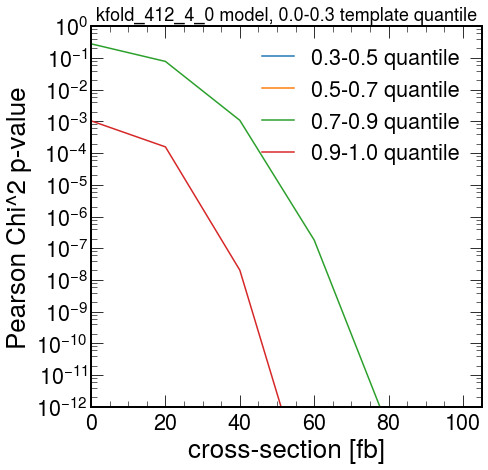

In [233]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('Pearson Chi^2 p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

### poisson likelihood pval

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


Text(0.5, 1.0, 'kfold_412_4_0 model, 0.0-0.3 template quantile')

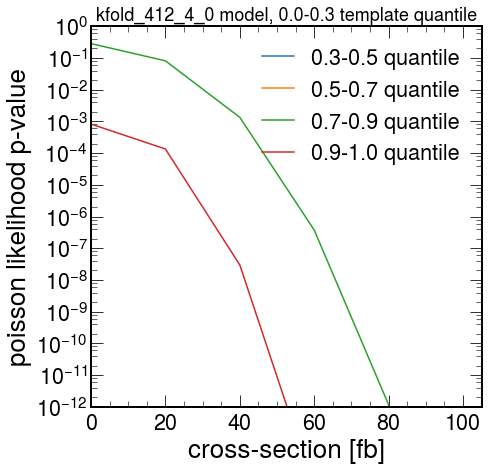

In [234]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    
    p_vals = []
    
    for xsec in xsecs_sig:
    
        t_l, _ = chi_square_poisson_likeli(dat[xsec], dat_tmplt[xsec]*eff)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        p_vals.append(pval_l)
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('poisson likelihood p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

## Kolmogorov-Smirnov 2-sample test

In [93]:
# empirical CDF
def ecdf(pdf):
    cdf = np.cumsum(pdf)
    return cdf / cdf[-1]

In [94]:
def kolmogorov_smirnov(observed, expected):
    obs_cdf = ecdf(observed)
    exp_cdf = ecdf(expected)
    return max(abs(obs_cdf-exp_cdf))

In [95]:
def pval_ks(ks_t, n, m):
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    en = m * n / (m + n)
    return kstwo.sf(ks_t, np.round(en))

In [96]:
ks_stats = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_ks = []
    pvals_ks = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        n, m = float(np.sum(observed)), float(np.sum(expected))
        t_ks = kolmogorov_smirnov(observed, expected)
        p_ks = pval_ks(t_ks, n, m)
        
        test_stat_xsecs_ks.append(t_ks)
        pvals_ks.append(p_ks)
    
    print('KS for quantile', quant_test)
    print('t:' , np.array(test_stat_xsecs_ks))
    print('p-val: ', np.array(pvals_ks))
    print('\n')
    
    ks_stats[quant_test] = test_stat_xsecs_ks

KS for quantile 0.3
t: [0.001 0.001 0.001 0.001 0.001 0.001]
p-val:  [0.2029 0.1998 0.1967 0.1937 0.1907 0.1877]


KS for quantile 0.5
t: [0.0033 0.0033 0.0034 0.0034 0.0034 0.0034]
p-val:  [1.8185e-11 1.4841e-11 1.2103e-11 9.8621e-12 8.0297e-12 6.5328e-12]


KS for quantile 0.7
t: [0.0037 0.0036 0.0036 0.0036 0.0035 0.0035]
p-val:  [4.4245e-14 9.5424e-14 2.0382e-13 4.3120e-13 8.6175e-13 1.6816e-12]


KS for quantile 0.9
t: [0.0009 0.0008 0.0007 0.0006 0.0006 0.0007]
p-val:  [0.7483 0.8433 0.9194 0.9692 0.9845 0.9124]




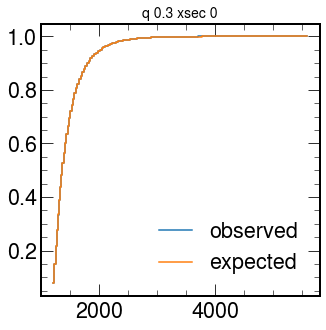

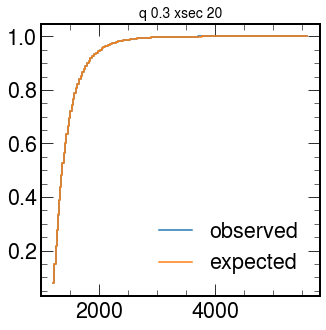

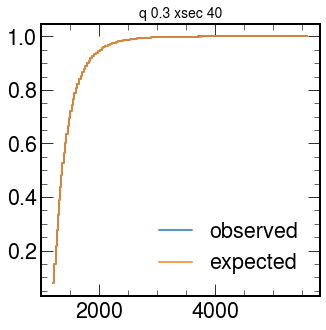

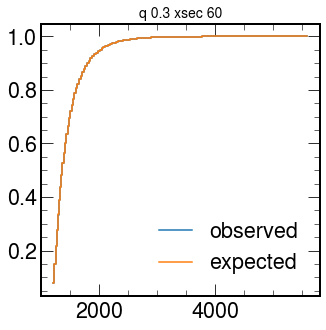

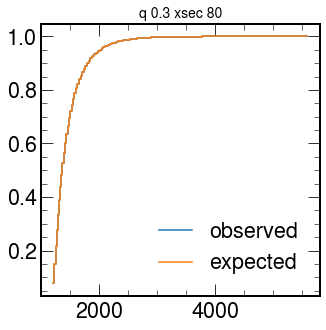

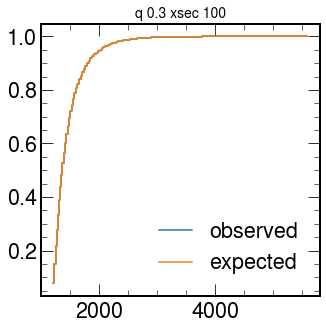

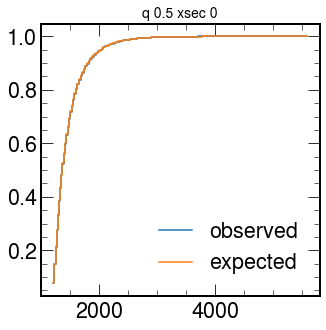

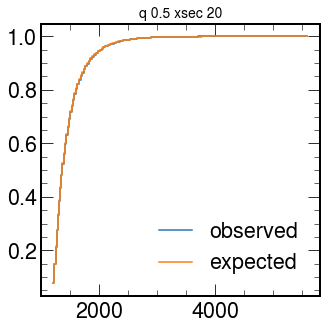

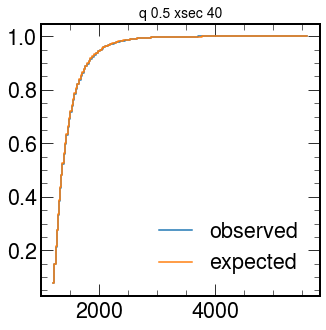

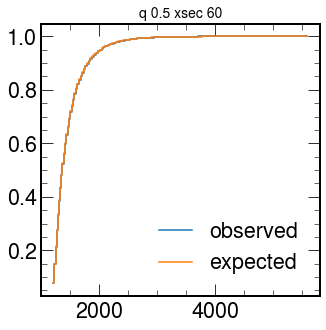

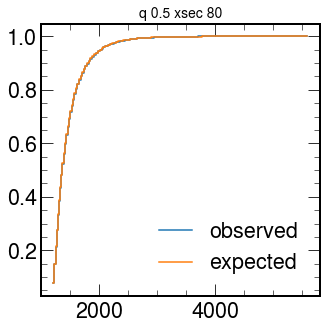

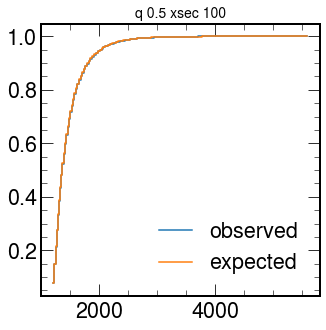

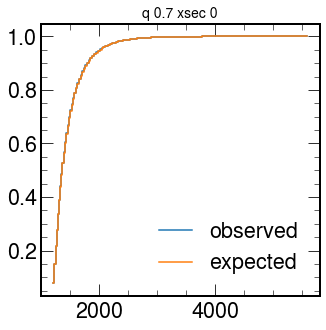

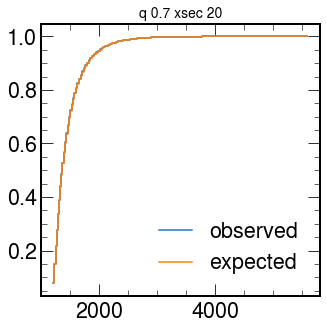

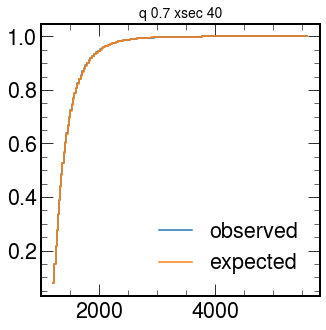

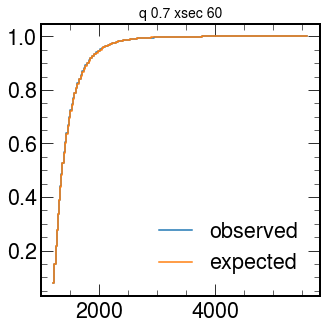

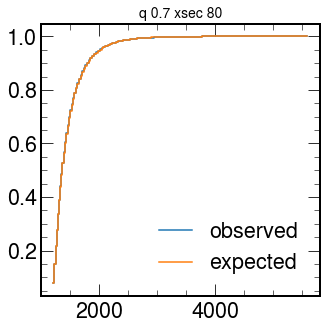

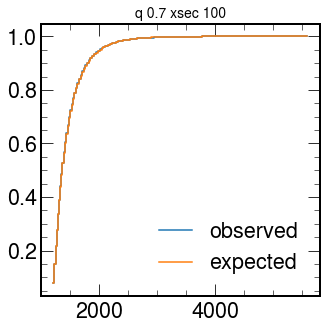

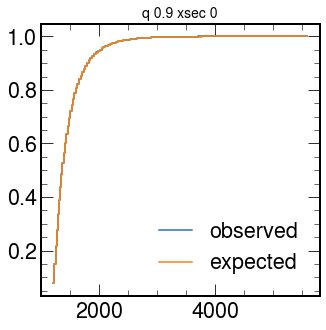

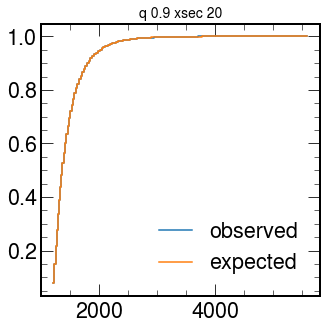

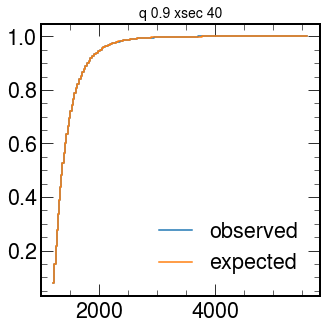

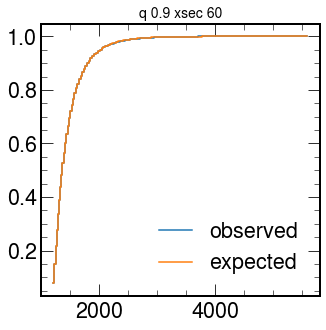

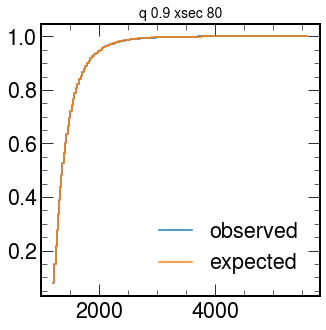

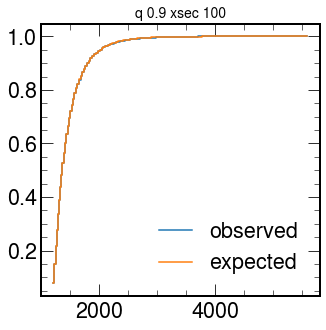

In [97]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


## KS from pdfs

In [44]:
mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quants, 113, params.qr_run_n, sample_id_sig, xsec_train, paths)

NameError: name 'paths' is not defined

In [ ]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


In [ ]:
len(mjj_vals_sig)

In [ ]:
def get_ks_test_stat_pval(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [ ]:
def get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2):
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [ ]:
s1 = np.random.normal(size=100000)
s2 = np.random.normal(size=100000)

In [ ]:
from scipy import stats
stats.ks_2samp(s1, s2)

In [ ]:
counts1, _, _ = plt.hist(s1, bins=100)
counts2, _, _ = plt.hist(s2, bins=100)
n1, n2 = float(len(s1)), float(len(s2))
cdf1 = np.cumsum(counts1)
cdf1 = cdf1 / cdf1[-1]
cdf2 = np.cumsum(counts2)
cdf2 = cdf2 / cdf2[-1]
t_ks, p_ks = get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2)

In [ ]:
print(t_ks, p_ks)

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(counts1, label='counts_1', drawstyle='steps-post')
plt.plot(counts2, label='counts_2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(cdf1, label='cdf1', drawstyle='steps-post')
plt.plot(cdf2, label='cdf2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [53]:
s1 = np.random.normal(loc=1, size=10000)
s2 = np.random.normal(loc=2, size=100)

In [54]:
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.379, pvalue=2.7766677845875165e-13)

In [55]:
s1 = np.random.normal(scale=1, size=10000)
s2 = np.random.normal(scale=2, size=100)
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.207, pvalue=0.0003385066199647069)